In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

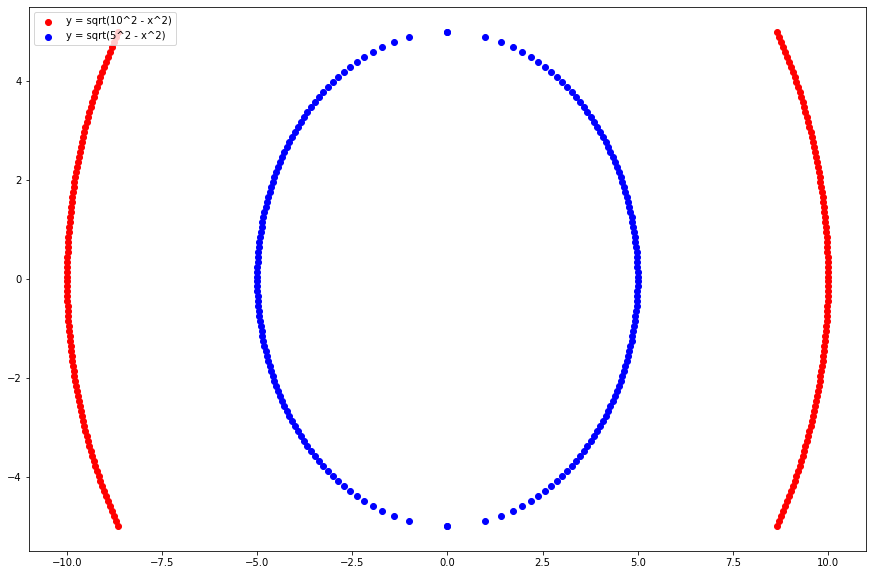

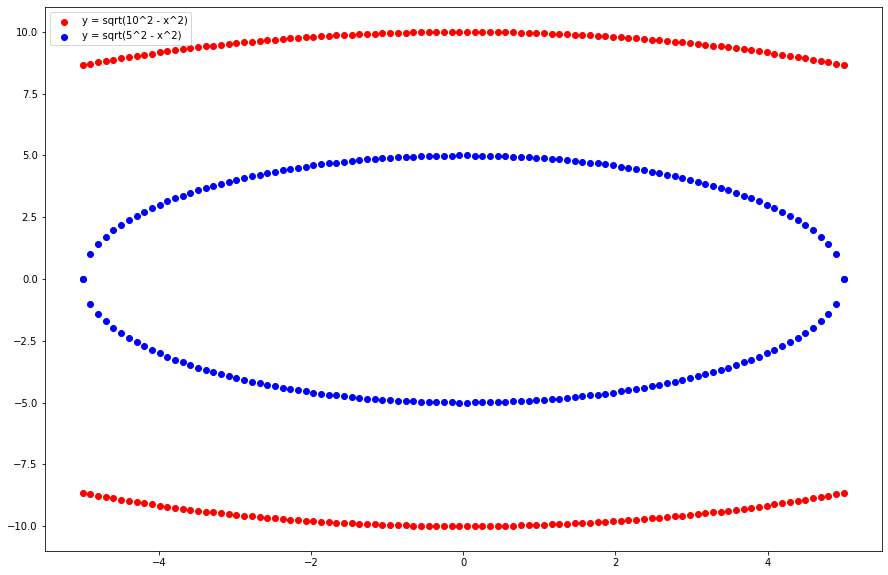

         X1       X2  Y
0  8.660254 -5.00000  0
1  8.717792 -4.89899  0
2  8.773790 -4.79798  0
3  8.828277 -4.69697  0
4  8.881281 -4.59596  0
Accuracy of SVM linear kernel classifier on test data: 0.46
Accuracy of SVM rbf kernel classifier on test data: 1.00


In [4]:
x = np.linspace(-5.0, 5.0, 100) # 100 linearly spaced numbers
y = np.sqrt(10**2 - x**2) 
y = np.hstack([y, -y])  # first set of points
x = np.hstack([x, -x])

x_1 = np.linspace(-5.0, 5.0, 100) # 100 linearly spaced numbers
y_1 = np.sqrt(5**2 - x_1**2)  # y_1 is the square root of x_1 squared
y_1 = np.hstack([y_1, -y_1])  # hstack stacks arrays in sequence horizontally (column wise) and in this case we are stacking y_1 and -y_1
x_1 = np.hstack([x_1, -x_1])  

plt.figure(figsize=(15, 10)) 
plt.scatter(y, x, color='red', label='y = sqrt(10^2 - x^2)')
plt.scatter(y_1, x_1, color='blue', label='y = sqrt(5^2 - x^2)')
plt.legend(loc='upper left')

plt.figure(figsize=(15, 10))
plt.scatter(x, y, color='red', label='y = sqrt(10^2 - x^2)')
plt.scatter(x_1, y_1, color='blue', label='y = sqrt(5^2 - x^2)')
plt.legend(loc='upper left')
plt.show()

df_1 = pd.DataFrame(np.vstack([y, x]).T, columns=['X1', 'X2'])
df_1['Y'] = 0

df_2 = pd.DataFrame(np.vstack([y_1, x_1]).T, columns=['X1', 'X2'])
df_2['Y'] = 1

df = df_1.append(df_2)
print(df.head())

# Independent and dependent features
X = df.iloc[:, :-1]
y = df.Y

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

SVM_classifier_linear = SVC(kernel='linear')
SVM_classifier_linear.fit(X_train, y_train)

linear_y_predict = SVM_classifier_linear.predict(X_test)
linear_accuracy = accuracy_score(y_test, linear_y_predict)
print('Accuracy of SVM linear kernel classifier on test data: {:.2f}'.format(linear_accuracy))

SVM_classifier_rbf = SVC(kernel='rbf')
SVM_classifier_rbf.fit(X_train, y_train)
rbf_y_predict = SVM_classifier_rbf.predict(X_test)
rbf_accuracy = accuracy_score(y_test, rbf_y_predict)
print('Accuracy of SVM rbf kernel classifier on test data: {:.2f}'.format(rbf_accuracy))

#### ***Linear Kernel***
$$ \text{Kernel}(x,y) = x^T y $$

$$ \lt f(x), f(y) \gt $$

#### ***Polynomial kernel***
$$ K(x, y) = (x^{T}y + c)^{d} $$
$x \text{ is } (x_{1} \text{ and } x_{2}) \text{ features}$
$$ \\ $$ 
$y \text{ is } (x_{1} \text{ and } x_{2}) \text{ features}$
$$ \\ $$
$d \text{ is number of wights in problem}$

#### ***Guassian kernel***  - ***Radial basis function (rbf) kernel***
$$ K(x, y) = \exp \left(-{\frac {\|\mathbf {x} -\mathbf {y} \|^{2}}{2\sigma ^{2}}}\right) $$


####  ***Sigmoid kernel***
$$ K(x, y) = \sigma \left( \frac {x^{T}y}{\|\mathbf {x} -\mathbf {y} \|} \right) $$

 
####  ***Laplas Kernel***
$$ K(x, y) = \frac {1}{\|\mathbf {x} - \mathbf {y} \|} $$


In [6]:
df = pd.read_csv("d2.csv", header=None)
print(df.head())
df.columns = ['X1', 'X2', 'Y']

# Calculating x^T * y matrix values
df["X1_Squared"] = df.X1**2
df["X2_Squared"] = df.X2**2
df["X1 * X2"] = df.X1*df.X2
print(df.head())

# Independent and dependent features
X = df.iloc[:, :-1]
y = df.Y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
# X_train, y_train

fig = px.scatter_3d(df, x="X1", y="X2", z="X1 * X2", color="X1")
fig.show()

fig = px.scatter_3d(df, x="X1_Squared", y="X2_Squared", z="X1 * X2", color="X1")
fig.show()

fig = px.scatter_3d(df, x="X1_Squared", y="X2_Squared", z="X1 * X2", color="Y")
fig.show()


          0        1  2
0  0.107140  0.60307  1
1  0.093318  0.64985  1
2  0.097926  0.70541  1
3  0.155530  0.78436  1
4  0.210830  0.86623  1
         X1       X2  Y  X1_Squared  X2_Squared   X1 * X2
0  0.107140  0.60307  1    0.011479    0.363693  0.064613
1  0.093318  0.64985  1    0.008708    0.422305  0.060643
2  0.097926  0.70541  1    0.009590    0.497603  0.069078
3  0.155530  0.78436  1    0.024190    0.615221  0.121992
4  0.210830  0.86623  1    0.044449    0.750354  0.182627


z_model-1:  (250000,)
z_model-2:  (500, 500)
z_model-3:  (500, 500)
z_model-1:  (250000,)
z_model-2:  (500, 500)
z_model-3:  (500, 500)
z_model-1:  (250000,)
z_model-2:  (500, 500)
z_model-3:  (500, 500)
z_model-1:  (250000,)
z_model-2:  (500, 500)
z_model-3:  (500, 500)
z_model-1:  (250000,)
z_model-2:  (500, 500)
z_model-3:  (500, 500)
z_model-1:  (250000,)
z_model-2:  (500, 500)
z_model-3:  (500, 500)
SKLearn rbf: 


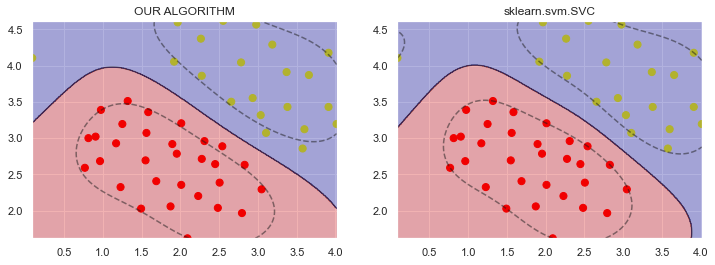

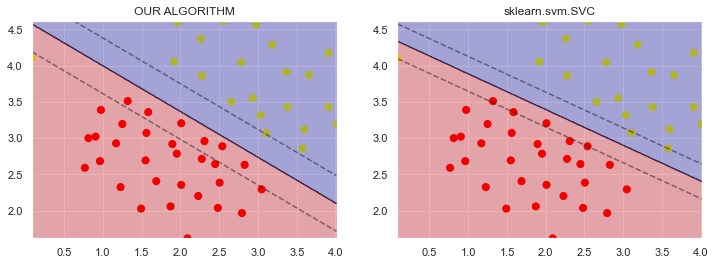

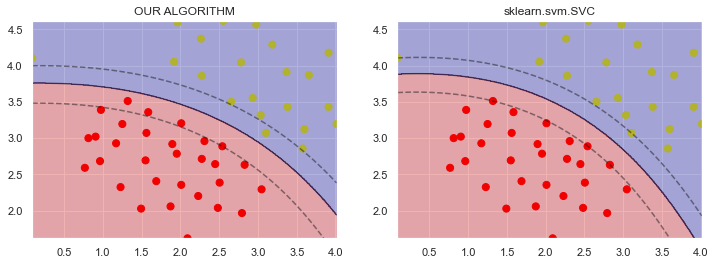

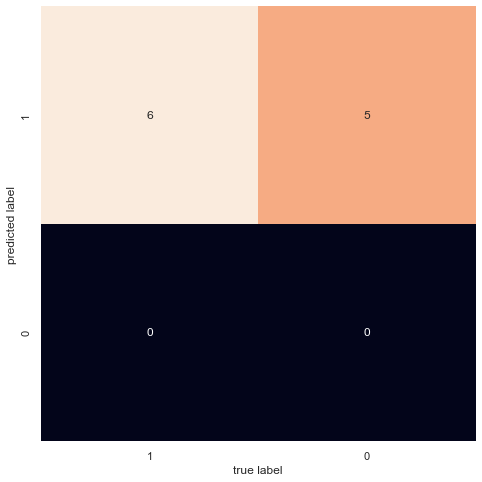

custom svm:


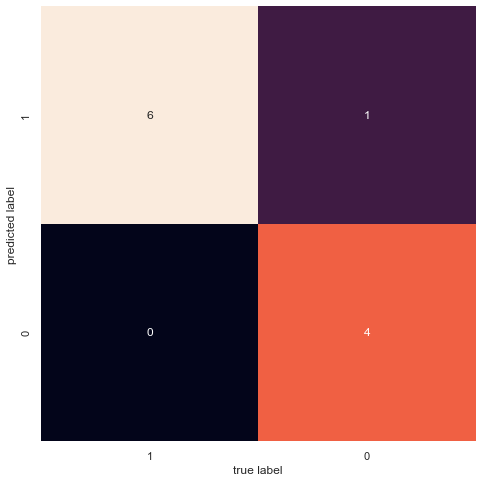

In [11]:
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs, make_circles
from sklearn import datasets, svm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np


class SVM:
    def __init__(self, kernel='linear', C=10000.0, max_iter=100000, degree=3, gamma=1):
        self.kernel = {'poly': lambda x, y: np.dot(x, y.T)**degree,
                       'rbf': lambda x, y: np.exp(-gamma*np.sum((y-x[:, np.newaxis])**2, axis=-1)),
                       'linear': lambda x, y: np.dot(x, y.T)}[kernel]
        self.C = C
        self.max_iter = max_iter

    #   
    def restrict_to_square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

    def fit(self, X, y):
        self.X = X.copy()
        #   0,1  -1,+1;     sklearn
        self.y = y * 2 - 1
        self.lambdas = np.zeros_like(self.y, dtype=float)
        #  (3)
        self.K = self.kernel(self.X, self.X) * self.y[:, np.newaxis] * self.y

        #  self.max_iter
        for _ in range(self.max_iter):
            #
            for idxM in range(len(self.lambdas)): # idxM is index of the margin
                # idxL
                idxL = np.random.randint(0, len(self.lambdas)) # idxL is index of the lambda
                #  (4)
                Q = self.K[[[idxM, idxM], [idxL, idxL]], # Q is the matrix of the quadratic term
                           [[idxM, idxL], [idxM, idxL]]] 
                #  (4a)
                v0 = self.lambdas[[idxM, idxL]]
                #  (4b)
                k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1) 
                #  (4d)
                u = np.array([-self.y[idxL], self.y[idxM]])
                #   (5),    idxM = idxL
                t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
                self.lambdas[[idxM, idxL]] = v0 + u * \
                    self.restrict_to_square(t_max, v0, u)

        #
        idx, = np.nonzero(self.lambdas > 1E-15)
        #  (1)
        self.b = np.mean(
            (1.0-np.sum(self.K[idx]*self.lambdas, axis=1))*self.y[idx])

    def decision_function(self, X):
        return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

    def predict(self, X):
        #   -1,+1  0,1;     sklearn
        return (np.sign(self.decision_function(X)) + 1) // 2

sns.set()

def test_plot(X, y, svm_model, axes, title):
    plt.axes(axes) 
    xlim = [np.min(X[:, 0]), np.max(X[:, 0])] # xlim is the x-axis limits
    ylim = [np.min(X[:, 1]), np.max(X[:, 1])] # ylim is the y-axis limits 
    xx, yy = np.meshgrid(np.linspace(*xlim, num=500), # meshgrid is used to return a coordinate grid of X and Y and n
                         np.linspace(*ylim, num=500))
    rgb = np.array([[210, 0, 0], [0, 0, 150]])/255.0 # rgb is the color of the points

    svm_model.fit(X, y)
    z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    print("z_model-1: ", z_model.shape)

    z_model = z_model.reshape(xx.shape) # z_model is the decision function of the model i.e. the value of the hyperplane and ravel
    print("z_model-2: ", z_model.shape)

    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn') # X[:, 0] is the first column of X, X[:, 1] is the second column of X and c=y means that the color of the points is the same as the class of the points
    print("z_model-3: ", z_model.shape)

    plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--']) # 
    plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
    plt.title(title)

dataset = pd.read_csv('d1.csv', header=None)
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# X, y = make_circles(100, factor=.1, noise=.1)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
test_plot(X, y, SVM(kernel='rbf', C=10, max_iter=10, gamma=1), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='rbf', C=10, gamma=1), axs[1], 'sklearn.svm.SVC')

# X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=1.4)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
test_plot(X, y, SVM(kernel='linear', C=10, max_iter=10), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='linear', C=10), axs[1], 'sklearn.svm.SVC')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
test_plot(X, y, SVM(kernel='poly', C=5, max_iter=10, degree=3), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='poly', C=5, degree=3), axs[1], 'sklearn.svm.SVC')

# class_A = 3
# class_B = 8

class_A = 1
class_B = 0

def plot_confusion(clf):
    clf.fit(X_train, y_train)
    y_fit = clf.predict(X_test)

    mat = confusion_matrix(y_test, y_fit)
    plt.figure(figsize=(8, 8))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=[class_A, class_B], yticklabels=[class_A, class_B])
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()


print('SKLearn rbf: ')
plot_confusion(svm.SVC(C=1.0, kernel='rbf', gamma=0.001))
print('custom svm:')
plot_confusion(SVM(kernel='rbf', C=1.0, max_iter=60, gamma=0.001))

test_cases = [ # (kernel, C, max_iter, gamma)
    ('linear', 1.0, 60, None),  
    ('poly', 1.0, 60, 3),
    ('rbf', 1.0, 60, 0.001)]

# # call test_cases
# for kernel, C, max_iter, gamma in test_cases:
#     print('kernel: {}, C: {}, max_iter: {}, gamma: {}'.format(
#         kernel, C, max_iter, gamma))
#     plot_confusion(SVM(kernel=kernel, C=C, max_iter=max_iter, gamma=gamma)) 

In [ ]:
# Support Vector Machine - Optimal Margin Calssifier
import numpy as np
import cvxopt
from utils import *
from sklearn.svm import SVC


def linear_kernel(x, z):
    return np.dot(x, z.T) 


def polynomial_kernel(x, z, p=5):
    return (np.dot(x, z.T) + 1) ** p # (x^T * z) + c where c is a constant


def guassian_kernel(x, z, sigma=.1):
    # e ^ (-||x - z||^2 / 2 * sigma^2) where ||x - z|| is L2 norm of difference between x and z
    return np.exp(-np.linalg.norm(x - z, axis=1)**2 / (2 * (sigma**2)))


class SVM():
    def __init__(self, kernel=guassian_kernel, C=1):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        self.X = X
        self.y = y
        m_samples, n_features = X.shape
        # calculate the kernel matrix
        self.K = np.zeros((m_samples, m_samples))
        # self.K = np.array([self.kernel(X[i], X[j]) for i in range(m_samples) for j in range(m_samples)])
        for i in range(m_samples):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)

        P = cvxopt.matrix(np.outer(y, y) * self.K) # P is a matrix of size m_samples x m_samples
        q = cvxopt.matrix(-np.ones((m_samples, 1))) # q is a vector of size m_samples x 1
        G = cvxopt.matrix(
            np.vstack((np.eye(m_samples) * -1, np.eye(m_samples)))) # G is a matrix of size 2m_samples x m_samples
        h = cvxopt.matrix(
            np.hstack((np.zeros(m_samples), np.ones(m_samples) * self.C))) # h is a vector of size 2m_samples x 1
        A = cvxopt.matrix(y, (1, m_samples), "d") # A is a vector of size 1 x m_samples
        b = cvxopt.matrix(np.zeros(1)) # b is a vector of size 1 x 1
        cvxopt.solvers.options['show_progress'] = False # 
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)  # sol is a dictionary with keys ['x', 'primal objective', 'status']
        self.alphas = np.array(sol['x'])

    def predict(self, X):
        y_predict = np.zeros((X.shape[0]))
        sv = self.get_params(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )
        return np.sign(y_predict + self.b)

    def get_params(self, alphas):
        threshold = 1e-4
        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(self.X[sv].T, alphas[sv]*self.y[sv, np.newaxis])
        self.b = np.mean(self.y[sv, np.newaxis] - self.alphas[sv]
                         * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis])
        return sv

if __name__ == '__main__':
    # np.random.seed(1)
    X, y = create_dataset(N=50)
    svm = SVM(kernel=guassian_kernel)
    svm.fit(X, y)
    y_pred = svm.predict(X)
    print('Accuracy: %.2f' % (np.mean(y_pred == y) * 100))
    plot_contour(X, y, svm)

    # SVM with SKLearn gussian kernel
    clf = SVC(C=10, kernel='rbf', gamma=10)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    print('Accuracy: %.2f' % (np.mean(y_pred == y) * 100))
    plot_contour(X, y, clf)

In [ ]:
# ToDo
# PART A: implement SVM
# test it on 'd1.csv'
# plot decision boundry including data
# Change C in range [0.1 - 1 - 10 - 100] and analyize output
# consider tolerance=0.001, max_passes=5


In [ ]:
# ToDo
# PART B: Implement Guassian Kernel
# Output shoud be approximatly as '324652.0'
# Consider x_1=[1;2;1], x_2=[0;4;-1], sigma=2.0

In [ ]:
# ToDo:
# Part C: Test algorithm on 'd2.csv'
# Plot decision boundry

In [ ]:
# ToDo:
# Part D: Test algorithm on 'd3.csv'
# Change C and sigma in range [0.001, 0.03, 0.1, 0.3, 1, 3, 10, 100]
# by considering accuracy get best parameters by tuning with validation data ('d3-validation.csv')

In [ ]:
# ToDo:
# Part E:
# plot decision boundry for train data
# plot decision boundry for validation data

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from sklearn.svm import SVC
import numpy as np 

from sklearn.datasets import make_circles

X, y = make_circles(100, factor=.1, noise=.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='bwr')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.34, shuffle=True)
classifier = SVC(kernel="rbf", C=1, gamma=100)
classifier.fit(X_train, y_train.ravel())
y_pred = classifier.predict(X_test)
# print(accuracy_score(y_test, y_pred))

distinct_colour = ListedColormap(['#FFAAAA', '#AAFFAA']) # Red and Green colors for the points
def plot_decision_boundry(X, y, classifier):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # value 1 is added to avoid points on the boundary and x_min and x_max are the min and max values of x, plus X
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # y_min and y_max are used to set the range of y axis
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), # meshgrid is used to create a grid of points
                            np.arange(y_min, y_max, 0.1))  # x_min, x_max, y_min, y_max are the range of x and y
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]) # xx.ravel() and yy.ravel() are used to flatten the grid because the grid is a 2D array and we need to convert it to a 1D array
    Z = Z.reshape(xx.shape) # we need to reshape the 1D array to the same shape as xx and yy
    plt.contourf(xx, yy, Z, cmap=distinct_colour, alpha=0.4) # countourf is used to plot the contour of the grid
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=distinct_colour) # scatter is used to plot the data points
    plt.xlim(xx.min(), xx.max()) # xlim is used to set the x-axis limits
    plt.ylim(yy.min(), yy.max()) # ylim is used to set the y-axis limits
    plt.show()

plot_decision_boundry(X, y, classifier)

In [ ]:
# ToDo:
# 1. Implement SVM using SMO algorithm
# 2. Implement SVM using SMO algorithm with kernel function
# 3. Implement SVM using SMO algorithm with kernel function and non-linear constraint
# 4. Implement SVM using SMO algorithm with kernel function and non-linear constraint and non-linear cost function


def linear_kernel(x_1, x_2):
    return np.dot(x_1, x_2)

def polynomial_kernel(x_1, x_2, p_degree):
    return (np.dot(x_1, x_2) + 1) ** p_degree

def gaussian_kernel(x_1, x_2, sigma):
    return np.exp(-np.linalg.norm(x_1 - x_2) ** 2 / (2 * sigma ** 2))

class SVM(object):
    def __init__(self, kernel_function, C, tolerance, max_passes):
        self.kernel_function = kernel_function
        self.C = C
        self.tolerance = tolerance
        self.max_passes = max_passes

    def fit(self, x_data, y_data):
        self.alpha, self.b = sequential_minimal_optimization(x_data, y_data, self.C, self.tolerance, self.max_passes)
        self.support_vectors = []
        self.support_vector_labels = []
        for i in range(len(self.alpha)):
            if self.alpha[i] > 0:
                self.support_vectors.append(x_data[i])
                self.support_vector_labels.append(y_data[i])
        self.support_vector_labels = np.array(self.support_vector_labels)

    def predict(self, x_data):
        predictions = []
        for x in x_data:
            kernel_sum = 0
            for i in range(len(self.alpha)):
                kernel_sum += self.alpha[i] * self.support_vector_labels[i] * self.kernel_function(self.support_vectors[i], x)
            predictions.append(kernel_sum + self.b)
        return np.sign(predictions)



def plot_decision_boundry(X, y, classifier):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # value 1 is added to avoid points on the boundary and x_min and x_max are the min and max values of x, plus X
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # y_min and y_max are used to set the range of y axis
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), # meshgrid is used to create a grid of points
                            np.arange(y_min, y_max, 0.1))  # x_min, x_max, y_min, y_max are the range of x and y
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]) # xx.ravel() and yy.ravel() are used to flatten the grid because the grid is a 2D array and we need to convert it to a 1D array
    Z = Z.reshape(xx.shape) # we need to reshape the 1D array to the same shape as xx and yy
    plt.contourf(xx, yy, Z, cmap=distinct_colour, alpha=0.4) # countourf is used to plot the contour of the grid
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=distinct_colour) # scatter is used to plot the data points
    plt.xlim(xx.min(), xx.max()) # xlim is used to set the x-axis limits
    plt.ylim(yy.min(), yy.max()) # ylim is used to set the y-axis limits
    plt.show()


In [ ]:
x_data, y_data  = make_circles(100, factor=.1, noise=.1)
plt.scatter(x_data[:, 0], x_data[:, 1], c=y_data, s=50, cmap='bwr')
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.34, shuffle=True)
svm = SVM(gaussian_kernel, 1, 0.001, 10)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

distinct_colour = ListedColormap(['#FFAAAA', '#AAFFAA']) # Red and Green colors for the points
plot_decision_boundry(x_data, y_data, svm)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# def linear_kernel(x, z):
#     return np.dot(x, z.T)

# def polynomial_kernel(x, z, p=5):
#     return (np.dot(x, z.T) + 1) ** p  # (x^T * z) + c where c is a constant

# def guassian_kernel(x, z, sigma=.1):
#     # e ^ (-||x - z||^2 / 2 * sigma^2) where ||x - z|| is L2 norm of difference between x and z
#     return np.exp(-np.linalg.norm(x - z, axis=1)**2 / (2 * (sigma**2)))


# def plot_decision_boundry(X, y, classifier):
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # value 1 is added to avoid points on the boundary and x_min and x_max are the min and max values of x, plus X
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # y_min and y_max are used to set the range of y axis
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), # meshgrid is used to create a grid of points
#                             np.arange(y_min, y_max, 0.1))  # x_min, x_max, y_min, y_max are the range of x and y
#     Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]) # xx.ravel() and yy.ravel() are used to flatten the grid because the grid is a 2D array and we need to convert it to a 1D array
#     Z = Z.reshape(xx.shape) # we need to reshape the 1D array to the same shape as xx and yy
#     plt.contourf(xx, yy, Z, cmap=distinct_colour, alpha=0.4) # countourf is used to plot the contour of the grid
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=distinct_colour) # scatter is used to plot the data points
#     plt.xlim(xx.min(), xx.max()) # xlim is used to set the x-axis limits
#     plt.ylim(yy.min(), yy.max()) # ylim is used to set the y-axis limits
#     plt.show()

# ToDo:
# 1. Implement SVM using SMO algorithm
 

# ToDo:
# Implementation of the Simplified SMO Algorithm
# input X, y, C, tolerance, max_passes
# output alphas, b - alphas: Lagrange multipliers, b: threshold


class SVM(object):
    def __init__(self, kernel, C, tolerance, max_passes, p_degree, sigma):
        self.kernel = kernel # kernel function
        self.C = C # C is the penalty parameter
        self.tolerance = tolerance # tolerance is used to determine when to stop the algorithm
        self.max_passes = max_passes # max_passes is the maximum number of passes through the dataset
        self.p_degree = p_degree # polynomial kernel dimension
        self.sigma = sigma # used for guassian kernel   
        self.alphas = None # Lagrange multipliers
        self.b = None   # threshold
        self.errors = None  # number of errors in each pass


    def linear(self, x, z): # x is a row vector, z is a column vector
        return np.dot(x, z.T)
    
    def polynomial(self, x_i, z_j, p_degree): # p_degree is the degree of the polynomial
        return (np.dot(x_i, z_j.T) + 1) ** p_degree

    def guassian(self, x_i, z_j, sigma): # sigma is the standard deviation and sigma^2 is the variance
        return np.exp(-np.linalg.norm(x_i - z_j, axis=1)**2 / (2 * (sigma**2)))

    # ToDo: Implementation of the Simplified SMO Algorithm
    # input:
    # C: regularization parameter
    # tolerance: tolerance for stopping criterion
    # max_passes: maximum # of times to iterate over alpha without changing
    # Output:
    # alpha: Lagrange multipliers for solution
    # b: threshold for solution
    def sequential_minimal_optimization(self, x_data, label_data, C, tolerance, max_passes):
        num_samples, num_features = x_data.shape

        # initialize alpha, b, passes
        alpha = np.zeros(num_samples)
        b = 0
        passes = 0
        while (passes < max_passes):
            num_changed_alphas = 0
            for i in range(num_samples):
                # set Error_i to the error for the ith training example
                # f(x^(i)) = sum(alpha_i * y^(i) * K(x^(i), x)) + b
                # Error_i = f(x^(i)) - y^(i)
                f_x_i = np.sum(alpha * label_data * self.kernel(x_data, x_data[i, :])) + b # check this line
                Error_i = f_x_i - label_data[i]
                # if ((y^(i) * Error_i < -tolerance and alpha[i] < C) or (y^(i) * Error_i > tolerance and alpha[i] > 0)):
                if ((label_data[i] * Error_i < -tolerance and alpha[i] < C) or (label_data[i] * Error_i > tolerance and alpha[i] > 0)):
                    # Select j != i randomly
                    j = i
                    while (j == i):
                        j = np.random.randint(num_samples)
                    # set Error_j to the error for the jth training example
                    # f(x^(j)) = sum(alpha_j * y^(j) * K(x^(j), x)) + b
                    # Error_j = f(x^(j)) - y^(j)
                    f_x_j = np.sum(alpha * label_data * self.kernel(x_data, x_data[j, :])) + b # check this line
                    Error_j = f_x_j - label_data[j]
                    # save old alpha_i, alpha_j
                    alpha_i_old = alpha[i]
                    alpha_j_old = alpha[j]
                    # if (y^(i) != y^(j)):
                    if (label_data[i] != label_data[j]):
                        L = max(0, alpha[j] - alpha[i])
                        H = min(C, C + alpha[j] - alpha[i])
                    else:
                        L = max(0, alpha[i] + alpha[j] - C)
                        H = min(C, alpha[i] + alpha[j])
                    if L == H:
                        continue
                    # Calculate eta = 2 * K(x^(i), x^(j)) - K(x^(i), x^(i)) - K(x^(j), x^(j))
                    eta = 2 * self.kernel(x_data[i, :], x_data[j, :]) - self.kernel(x_data[i, :], x_data[i, :]) - self.kernel(x_data[j, :], x_data[j, :])
                    if eta >= 0:
                        continue
                    # update alpha_j to satisfy: 0 <= alpha_j <= C
                    # alpha_j = alpha_j - y^(j) * (Error_i - Error_j) / eta
                    alpha[j] = alpha[j] - label_data[j] * (Error_i - Error_j) / eta
                    # clip alpha_j if it's out of range
                    if alpha[j] > H:
                        alpha[j] = H
                    if alpha[j] < L:
                        alpha[j] = L
                    if abs(alpha[j] - alpha_j_old) < 1e-5:
                        continue
                    # update alpha_i to satisfy: 0 <= alpha_i <= C - alpha_j
                    # alpha_i = alpha_i + y^(i) * y^(j) * (alpha_j_old - alpha_j)
                    alpha[i] = alpha[i] + label_data[i] * label_data[j] * (alpha_j_old - alpha[j])
                    # update b to satisfy: Error_i - Error_j = b - Error_i - Error_j
                    # b = b + y^(i) * (alpha_i_old - alpha_i) - y^(j) * (alpha_j_old - alpha_j)
                    b1 = b - Error_i - label_data[i] * (alpha[i] - alpha_i_old) * self.kernel(x_data[i, :], x_data[i, :]) - label_data[j] * (alpha[j] - alpha_j_old) * self.kernel(x_data[i, :], x_data[j, :])
                    b2 = b - Error_j - label_data[i] * (alpha[i] - alpha_i_old) * self.kernel(x_data[i, :], x_data[j, :]) - label_data[j] * (alpha[j] - alpha_j_old) * self.kernel(x_data[j, :], x_data[j, :])
                    if 0 < alpha[i] and alpha[i] < C:
                        b = b1
                    elif 0 < alpha[j] and alpha[j] < C:
                        b = b2
                    else:
                        b = (b1 + b2) / 2
                    num_changed_alphas += 1
            if num_changed_alphas == 0:
                passes += 1
            else:    
                passes = 0
        return alpha, b

    def fit(self, x_data, label_data, C, tolerance, max_passes):
        self.alpha, self.b = self.sequential_minimal_optimization(x_data, label_data, C, tolerance, max_passes)
        self.w = np.dot(self.alpha * label_data, x_data)
        
        self.support_vectors = x_data[np.nonzero(self.alpha)[0]]
        self.support_vector_labels = label_data[np.nonzero(self.alpha)[0]]
        self.support_vector_alphas = self.alpha[np.nonzero(self.alpha)[0]]

        self.b = self.b - np.sum(self.support_vector_alphas * self.support_vector_labels * self.kernel(self.support_vectors, x_data))

    def predict(self, x_data):
        return np.sign(np.dot(self.w, x_data) + self.b)
    
    def score(self, x_data, label_data):
        return np.mean(self.predict(x_data) == label_data)

    def get_params(self, deep=True):
        return {'kernel': self.kernel, 'C': self.C, 'tolerance': self.tolerance, 'max_passes': self.max_passes}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def __str__(self):
        return 'SVM(kernel=%s, C=%s, tolerance=%s, max_passes=%s)' % (self.kernel, self.C, self.tolerance, self.max_passes)

    def plot_decision_boundry(self, x_data, label_data):
        x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
        y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_labels = self.predict(grid_points)
        grid_labels = grid_labels.reshape(xx.shape)
        plt.contourf(xx, yy, grid_labels, cmap=plt.cm.Paired, alpha=0.8)
        plt.scatter(x_data[:, 0], x_data[:, 1], c=label_data, cmap=plt.cm.Paired)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.show()


In [ ]:
data = pd.read_csv("./d1.csv")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Initalize the SVM

svm = SVM(gaussian, 
svm.fit(X, y)
y_pred = svm.predict(X)